## 📈 Amazon Stock Price Prediction Using LSTM

In this project, I developed a deep learning model using Long Short-Term Memory (LSTM) networks to predict the stock price of Amazon (AMZN). LSTM models are particularly well-suited for time series data due to their ability to capture long-term dependencies. Historical stock data was obtained from Yahoo Finance, and the model was trained to forecast future closing prices using technical indicators and sequence patterns.


## 📦 Importing Libraries

We begin by importing essential Python libraries for data loading, preprocessing, visualization, and modeling.


In [1]:
# 📦 Import Libraries
import math
!pip install ta
import ta
import pandas_datareader as web
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
plt.style.use('fivethirtyeight')

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=edec4362ac1fda65634ae6d7f8a7c89e0fa2578699661ec06a420cbf0dd7c59e
  Stored in directory: /root/.cache/pip/wheels/a1/d7/29/7781cc5eb9a3659d032d7d15bdd0f49d07d2b24fec29f44bc4
Successfully built ta


## 📥 Fetching Amazon Stock Data

We will retrieve Amazon's historical stock data from Yahoo Finance using the `yfinance` library from January 1, 2015 to March 19, 2025.


In [2]:
#get the stock quote
df = yf.download('AMZN', start='2015-01-01', end='2025-03-19')
#show the data
df


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,AMZN,AMZN,AMZN,AMZN,AMZN
Date,,,,,
2015-01-02,15.426000,15.737500,15.348000,15.629000,55664000
2015-01-05,15.109500,15.419000,15.042500,15.350500,55484000
2015-01-06,14.764500,15.150000,14.619000,15.112000,70380000
2015-01-07,14.921000,15.064000,14.766500,14.875000,52806000
2015-01-08,15.023000,15.157000,14.805500,15.016000,61768000
...,...,...,...,...,...
2025-03-12,198.889999,201.520004,195.289993,200.720001,43679300
2025-03-13,193.889999,198.880005,191.820007,198.169998,41270800


In [3]:
#number of ros and column in a data set
df.shape

(2567, 5)

##Visualise the closing price history



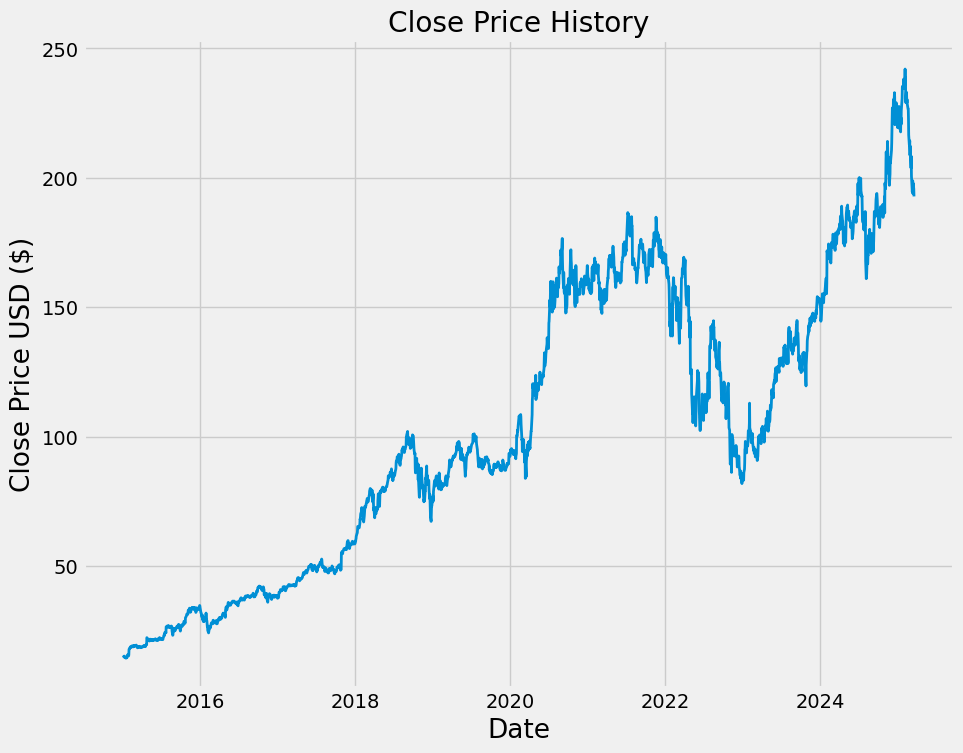

In [4]:
#visualise the closing price history
plt.figure(figsize=(10,8))
plt.title('Close Price History')
plt.plot(df['Close'],linewidth=2)
plt.xlabel('Date', fontsize=19)
plt.ylabel('Close Price USD ($)', fontsize=19)
plt.show()

## 📊 Feature Engineering & Technical Indicators

To enhance the model's predictive performance, several technical indicators were used as additional features.


### ✅ Simple Moving Average (SMA)

**Description:** The Simple Moving Average smooths out price data to identify the direction of a trend. Two SMAs were used:
- 30-day SMA (short-term)
- 100-day SMA (long-term)


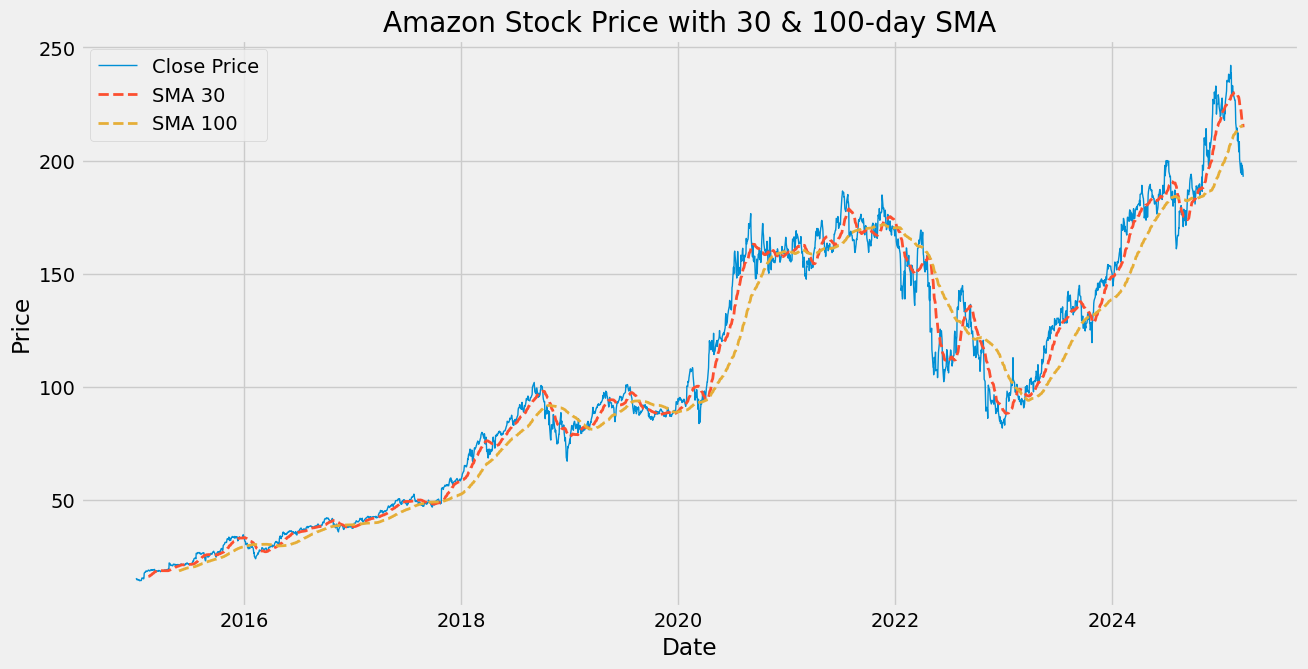

In [6]:
# Simple Moving Averages
# Instead of using .values, directly pass the pandas Series to the function, and use squeeze() if needed to ensure it is 1D.
df['SMA_30'] = ta.trend.sma_indicator(df['Close'].squeeze(), window=30)
df['SMA_100'] = ta.trend.sma_indicator(df['Close'].squeeze(), window=100)
# Plot
plt.figure(figsize=(14, 7))
plt.plot(df['Close'], label='Close Price', linewidth=1)
plt.plot(df['SMA_30'], label='SMA 30', linestyle='--',linewidth=2)
plt.plot(df['SMA_100'], label='SMA 100', linestyle='--',linewidth=2)
plt.title('Amazon Stock Price with 30 & 100-day SMA')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

### 🔥 Feature Correlation

We explore the correlation between stock features to identify strong relationships. This helps us decide what features could be useful for modeling.


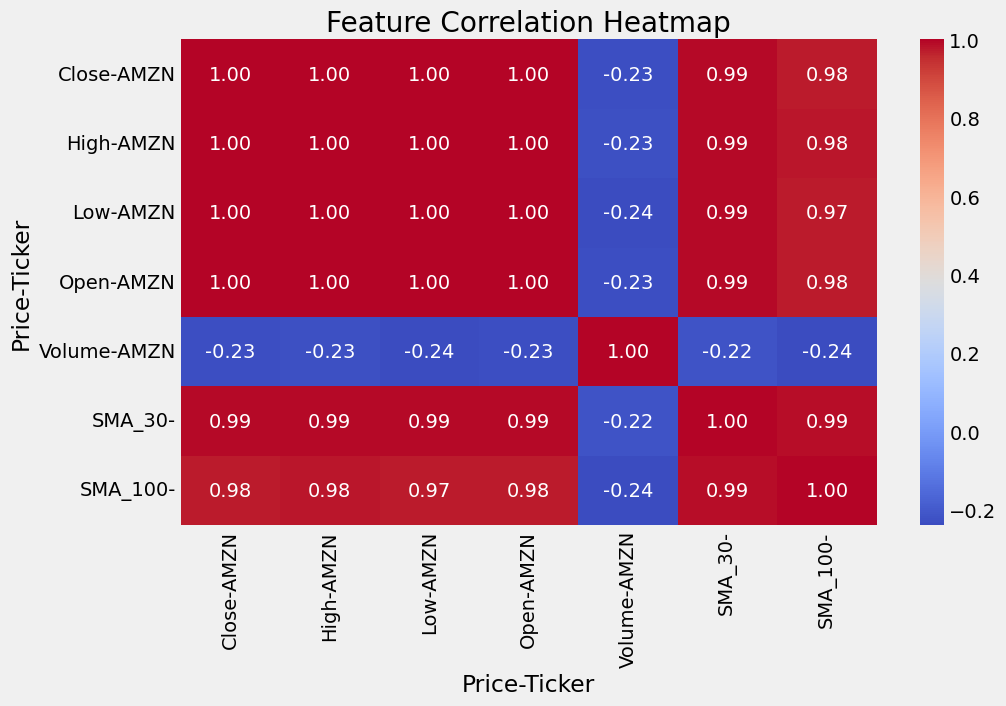

In [7]:
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Feature Correlation Heatmap')
plt.show()


### ⚠️ Volatility Analysis

We plot rolling standard deviation (30-day window) to measure price volatility. Spikes in volatility often indicate high-risk or high-reward market periods.


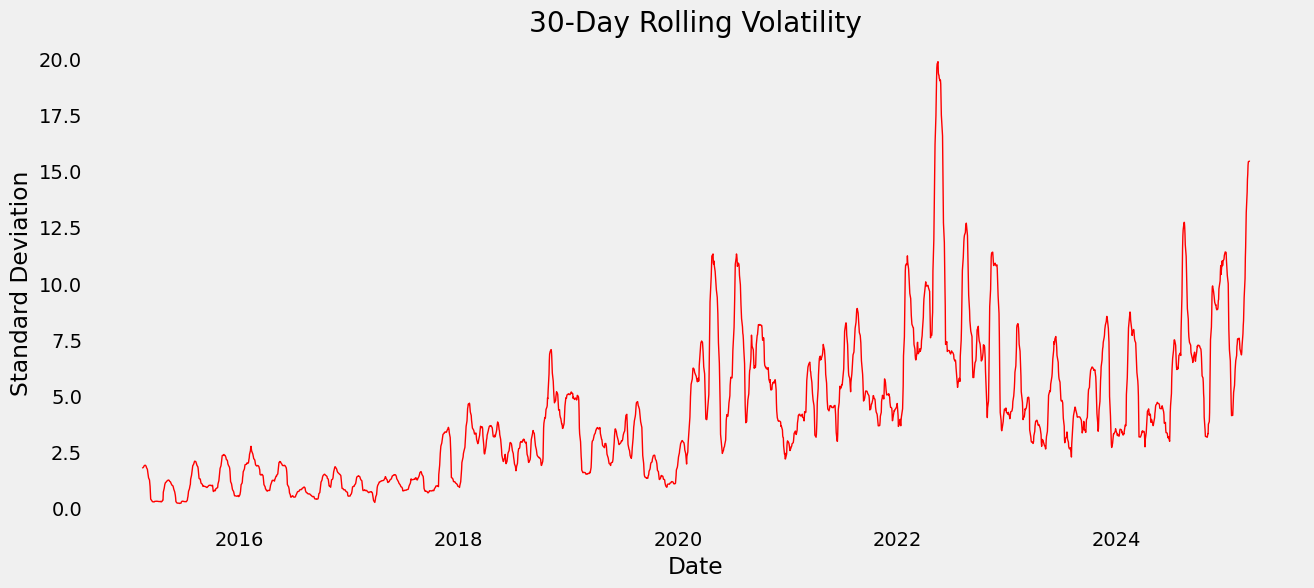

In [8]:
df['Volatility_30'] = df['Close'].rolling(window=30).std()

plt.figure(figsize=(14, 6))
plt.plot(df['Volatility_30'], color='red',linewidth=1)
plt.title('30-Day Rolling Volatility')
plt.xlabel('Date')
plt.ylabel('Standard Deviation')
plt.grid()
plt.show()


### ✅ Relative Strength Index (RSI)
**Description:** RSI is a momentum oscillator that measures the speed and change of price movements. It helps identify overbought (above 70) or oversold (below 30) conditions.

---

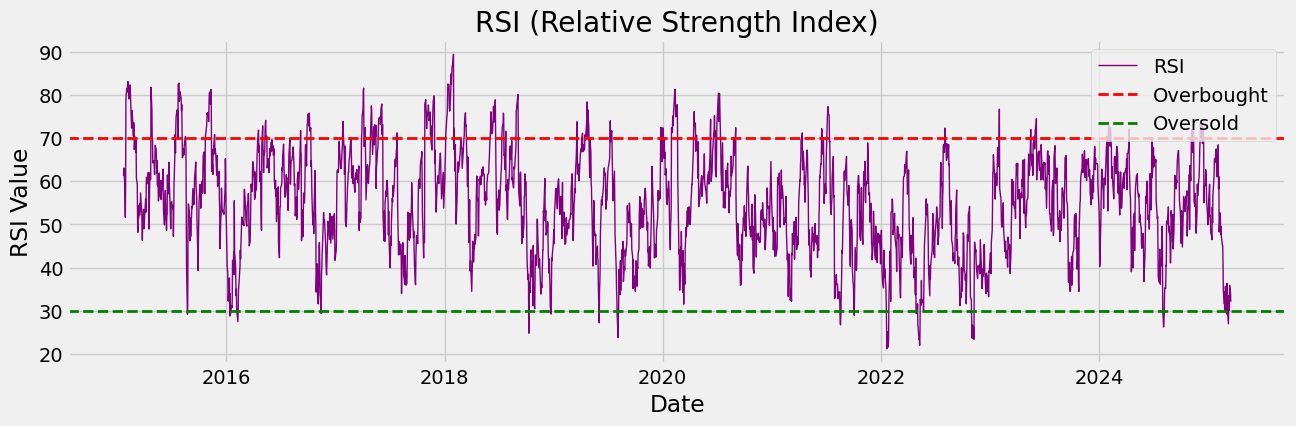

In [9]:
# Relative Strength Index
df['RSI'] = ta.momentum.rsi(df['Close'].squeeze(), window=14)
#Plot
plt.figure(figsize=(14, 4))
plt.plot(df['RSI'], label='RSI', color='purple',linewidth=1)
plt.axhline(70, linestyle='--', color='red', label='Overbought',linewidth=2)
plt.axhline(30, linestyle='--', color='green', label='Oversold', linewidth=2)
plt.title('RSI (Relative Strength Index)')
plt.xlabel('Date')
plt.ylabel('RSI Value')
plt.legend()
plt.grid(True)
plt.show()


### ✅ MACD (Moving Average Convergence Divergence)
**Description:** MACD is a trend-following momentum indicator that shows the relationship between two moving averages of a stock's price. It helps identify potential buy/sell signals when the MACD line crosses the signal line.


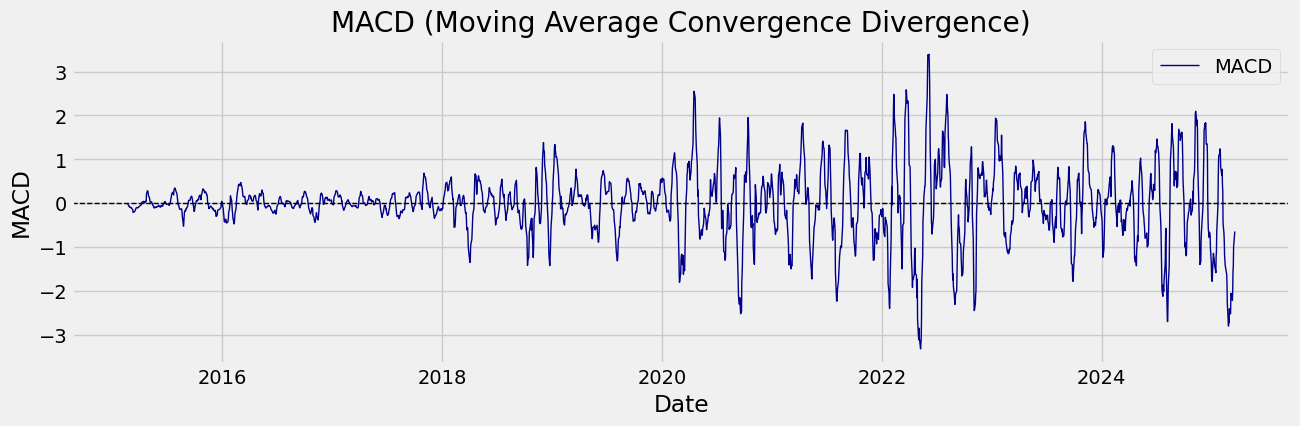

In [10]:
# MACD
df['MACD'] = ta.trend.macd_diff(df['Close'].squeeze())
#Plot
plt.figure(figsize=(14, 4))
plt.plot(df['MACD'], label='MACD', color='darkblue',linewidth=1)
plt.axhline(0, color='black', linewidth=1, linestyle='--')
plt.title('MACD (Moving Average Convergence Divergence)')
plt.xlabel('Date')
plt.ylabel('MACD')
plt.legend()
plt.grid(True)
plt.show()

### ✅ Bollinger Bands
**Description:** Bollinger Bands are a volatility indicator composed of a moving average (typically 20-day) and two standard deviation bands above and below it. They help identify potential breakout or reversal zones by showing when prices are relatively high or low.

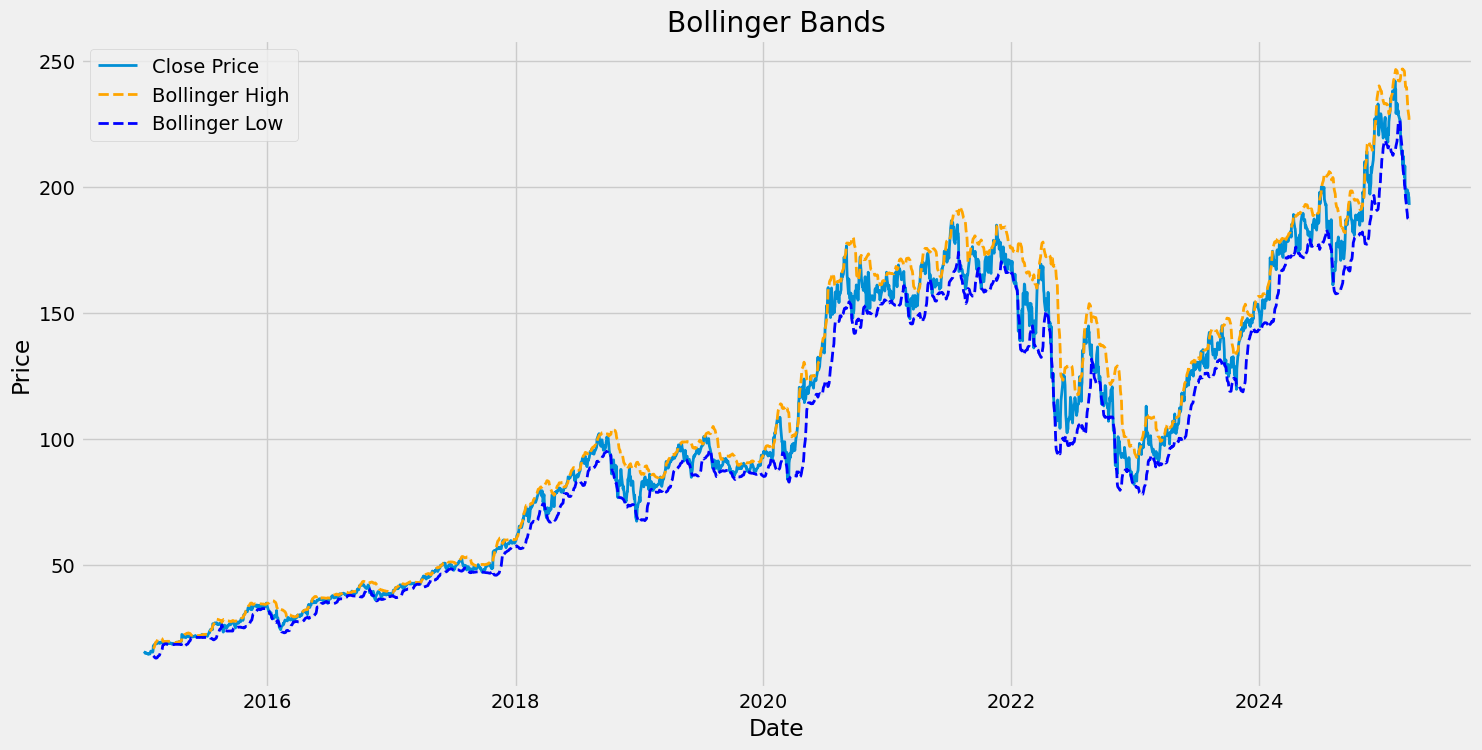

In [11]:
# Bollinger Bands
df['Bollinger_High'] = ta.volatility.bollinger_hband(df['Close'].squeeze())
df['Bollinger_Low'] = ta.volatility.bollinger_lband(df['Close'].squeeze())
#Plot
plt.figure(figsize=(16, 8))
plt.plot(df['Close'], label='Close Price',linewidth=2)
plt.plot(df['Bollinger_High'], label='Bollinger High', linestyle='--', color='orange',linewidth=2)
plt.plot(df['Bollinger_Low'], label='Bollinger Low', linestyle='--', color='blue', linewidth=2)
plt.fill_between(df.index, df['Bollinger_Low'], df['Bollinger_High'], color='lightgrey', alpha=0.3)
plt.title('Bollinger Bands')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


### ✅ Average True Range (ATR)
**Description:** ATR measures market volatility by decomposing the entire range of an asset price for that period. Higher ATR indicates more volatility.


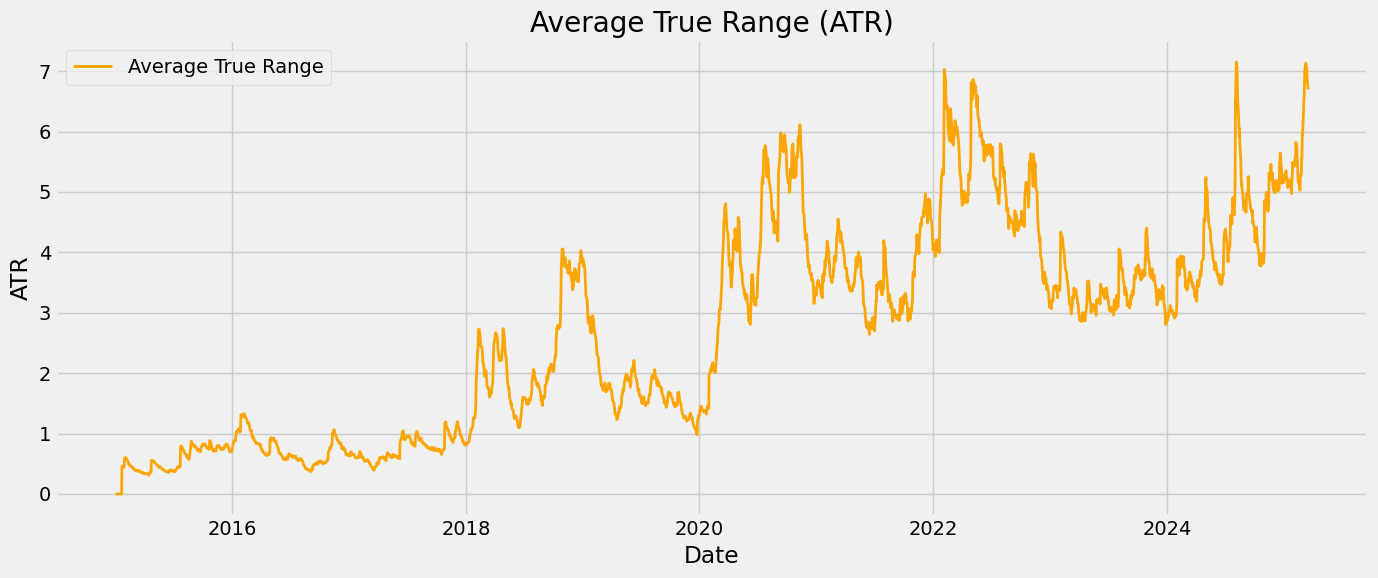

In [12]:
df['ATR'] = ta.volatility.average_true_range(df['High'].squeeze(), df['Low'].squeeze(), df['Close'].squeeze())  # Similar change here
#Plot
plt.figure(figsize=(14,6))
plt.plot(df.index, df['ATR'], label='Average True Range', color='orange',linewidth=2)
plt.title('Average True Range (ATR)')
plt.xlabel('Date')
plt.ylabel('ATR')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 🧹 Data Preprocessing

The dataset was collected using the yfinance Python library, covering Amazon stock prices from January 2015 to March 2025. Missing values (NaNs) were handled using df.dropna() to ensure clean input for the model. Important features such as the 30-day and 100-day Simple Moving Averages (SMA), and 30-day volatility were engineered to enrich the input data.


In [16]:
# featurest
data = df[['Open', 'High', 'Low', 'Volume', 'Close', 'SMA_30', 'SMA_100', 'RSI', 'MACD', 'ATR']]

# Add Volatility_30
data['Volatility_30'] = df['Close'].rolling(window=30).std()

# Add Bollinger Bands
data['Bollinger_High'] = df['Bollinger_High']
data['Bollinger_Low'] = df['Bollinger_Low']

# Remove any rows with NaN values (due to rolling calculations)
data.dropna(inplace=True)
dataset = data.values
training_data_len = math.ceil(len(dataset) * 0.8)
training_data_len


<ipython-input-16-daa0d1bc4193>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Volatility_30'] = df['Close'].rolling(window=30).std()
<ipython-input-16-daa0d1bc4193>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Bollinger_High'] = df['Bollinger_High']


1975

In [17]:
#scale the data
scaler=MinMaxScaler(feature_range=(0,1))
scaled_data=scaler.fit_transform(dataset)
scaled_data

array([[1.03041577e-03, 1.14160652e-03, 1.35207509e-03, ...,
        3.78738522e-02, 5.06966809e-05, 3.94059117e-03],
       [1.54907291e-03, 1.02856951e-03, 1.45803353e-03, ...,
        3.49519059e-02, 0.00000000e+00, 3.92802531e-03],
       [9.79928884e-04, 1.28854255e-03, 1.86342409e-03, ...,
        3.20930036e-02, 3.39729659e-05, 4.07159194e-03],
       ...,
       [8.09016303e-01, 8.01654718e-01, 8.03245950e-01, ...,
        7.73517268e-01, 9.28693815e-01, 8.11269329e-01],
       [8.15258503e-01, 8.03237167e-01, 7.98639205e-01, ...,
        7.74395467e-01, 9.15857925e-01, 8.09303273e-01],
       [7.86571936e-01, 7.80631145e-01, 7.75881872e-01, ...,
        7.76074741e-01, 9.03562651e-01, 8.06315630e-01]])

In [19]:
#create the training data set and scaled training data set
train_data = scaled_data[0:training_data_len, :]
# splitting into x and y train data sets
x_train = []
y_train = []
for i in range (150, len(train_data)):
    x_train.append(train_data[i-150:i, 0])
    y_train.append(train_data[i, 0])
    if i<=151:
        print(x_train)
        print(y_train)
        print()


[array([0.00103042, 0.00154907, 0.00097993, 0.00170742, 0.00163169,
       0.00262539, 0.00262539, 0.0015376 , 0.00061045, 0.        ,
       0.00080322, 0.00214116, 0.00190249, 0.00107861, 0.00027309,
       0.00123925, 0.00168447, 0.00397022, 0.00322207, 0.00289848,
       0.00505113, 0.00346763, 0.00431445, 0.0027585 , 0.00257949,
       0.00376138, 0.00322207, 0.00281587, 0.00291914, 0.00261392,
       0.00274014, 0.004023  , 0.00581304, 0.00903282, 0.00919806,
       0.00976261, 0.01256242, 0.01597497, 0.01490324, 0.01446491,
       0.01576614, 0.03580771, 0.02404852, 0.02594183, 0.02477601,
       0.02402557, 0.02665097, 0.0262746 , 0.02449374, 0.02658442,
       0.02669916, 0.02437211, 0.02422523, 0.0231076 , 0.02313055,
       0.02396131, 0.02416327, 0.02486093, 0.02572152, 0.02542318,
       0.02465438, 0.01936917, 0.00932199, 0.01480915, 0.01401281,
       0.02082644, 0.02169622, 0.02145296, 0.01748274, 0.01884822,
       0.02100775, 0.01714079, 0.01967439, 0.02318793, 0.0211

In [20]:
#convert x_train and y_train to numpy arrays
x_train , y_train = np.array(x_train) , np.array(y_train)



In [21]:
#reshape the data
x_train = np.reshape(x_train,(x_train.shape[0], x_train.shape[1] , 1))
x_train.shape

(1825, 150, 1)

A stacked LSTM model was used with two LSTM layers followed by a dense output layer. The model was trained using the Adam optimizer and Mean Squared Error (MSE) loss function. An 80-20 split was applied to divide the data into training and testing sets.



In [22]:
# Build LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))  # Prediction for Close price


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [23]:
#compile the model
model.compile(optimizer='adam' , loss = 'mean_squared_error')

In [24]:
model.fit(x_train, y_train, batch_size=1, epochs=1)


1825/1825 ━━━━━━━━━━━━━━━━━━━━ 120s 64ms/step - loss: 0.0071


In [25]:
#creating the testing data set
# Get the remaining data for testing after training
test_dataset = scaled_data[training_data_len - 150:, :]

# Initialize the x_test and y_test lists for the test set
x_test = []
y_test = []  # Initialize y_test here

# Loop through the test_dataset to populate x_test and y_test
for i in range(150, len(test_dataset)):
    x_test.append(test_dataset[i - 150:i, 0])
    y_test.append(test_dataset[i, 0])  # Appending the corresponding target to y_test

# Convert the x_test and y_test lists to NumPy arrays
x_test = np.array(x_test)
y_test = np.array(y_test)  # Convert y_test to a NumPy array

# Reshape x_test to match the expected input shape of the LSTM model
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))


# Train model
history = model.fit(x_train, y_train, epochs=50, batch_size=32, validation_data=(x_test, y_test))

Epoch 1/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 133ms/step - loss: 0.0020 - val_loss: 0.0011
Epoch 2/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 11s 145ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 3/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 146ms/step - loss: 0.0014 - val_loss: 9.8032e-04
Epoch 4/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 139ms/step - loss: 0.0013 - val_loss: 7.1672e-04
Epoch 5/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 9s 123ms/step - loss: 0.0012 - val_loss: 7.2783e-04
Epoch 6/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 123ms/step - loss: 0.0010 - val_loss: 8.4004e-04
Epoch 7/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 11s 132ms/step - loss: 0.0010 - val_loss: 7.4716e-04
Epoch 8/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 11s 145ms/step - loss: 9.4939e-04 - val_loss: 6.5292e-04
Epoch 9/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 12s 171ms/step - loss: 0.0012 - val_loss: 7.0276e-04
Epoch 10/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 7s 123ms/step - loss: 0.0011 - val_loss: 7.6929e-04
Epoch 11/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 123ms/step - loss: 0.0010 - val_loss: 7.4867e-04
Epo

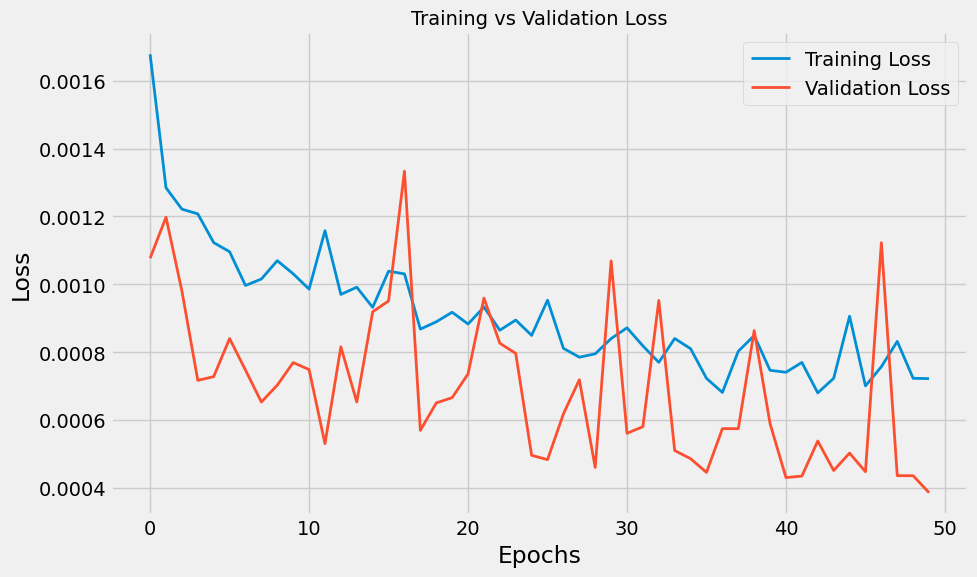

In [49]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Training vs Validation Loss', fontsize=14)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Save the figure (optional)
plt.savefig("loss_curve.png", dpi=300)

# Show the plot
plt.show()


## 📉 Making Predictions and Evaluating Model

We will:
- Make predictions on the test data.
- Inverse transform the predictions.
- Calculate error metrics such as RMSE, MAE and R² score  to evaluate the performance.

In [29]:
# Predictions using x_test
y_pred = model.predict(x_test)

# Reshape predictions to have the same number of features as the original dataset
predictions_2D = np.repeat(y_pred, dataset.shape[1], axis=1)  # Repeat across 13 features

# Inverse transform predictions
predictions_inv = scaler.inverse_transform(predictions_2D)[:, 0]  # Extract the 'Close' price

# Reshape y_test to have the same number of features as the original dataset
y_test_2D = np.repeat(y_test.reshape(-1, 1), dataset.shape[1], axis=1)

# Inverse transform y_test
y_test_inv = scaler.inverse_transform(y_test_2D)[:, 0]  # Extract the 'Close' price



16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step


In [30]:
# Calculate RMSE,MAE and R²
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score # Import necessary functions

rmse = np.sqrt(mean_squared_error(y_test_inv, predictions_inv))
mae = mean_absolute_error(y_test_inv, predictions_inv)
r2 = r2_score(y_test_inv, predictions_inv)

# Now you can print RMSE and MAE
print(f"Root Mean Square Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R² Score: {r2}")

Root Mean Square Error (RMSE): 4.28
Mean Absolute Error (MAE): 3.2131404760643143
R² Score: 0.9854853590832651


<ipython-input-32-c314b60a3e80>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions_inv


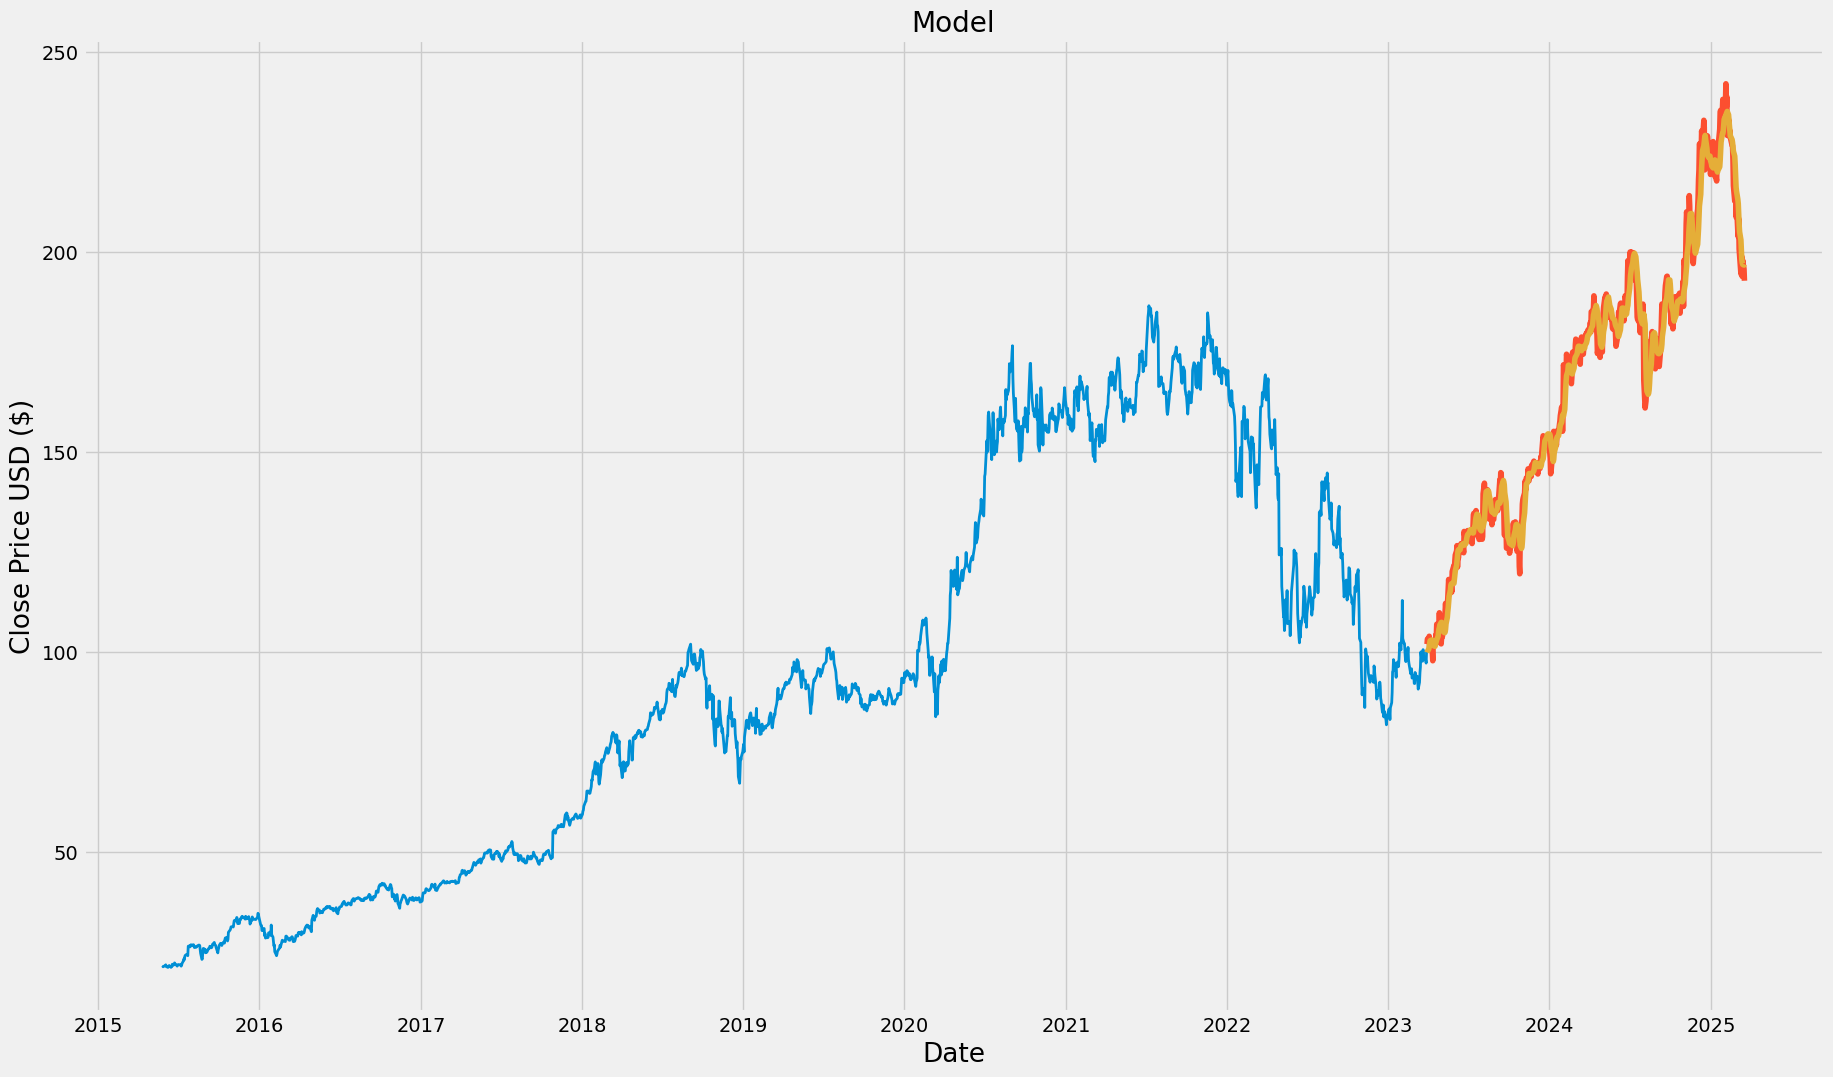

In [32]:
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions_inv
plt.figure(figsize=(20,12))
plt.title('Model')
plt.xlabel('Date', fontsize=19)
plt.ylabel('Close Price USD ($)', fontsize=19)
plt.plot(train['Close'],linewidth=2)
plt.plot(valid[['Close', 'Predictions']])

RMSE: 5.69
MAE: 4.45
R² Score: 0.9707


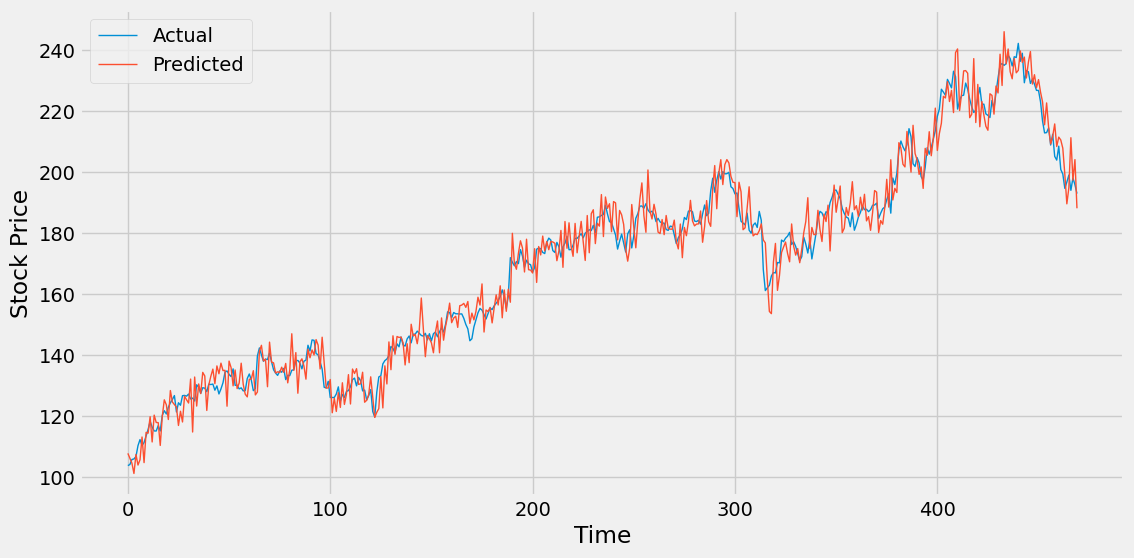

In [34]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Features you're using
features = ['Open', 'High', 'Low', 'Volume', 'Close', 'SMA_30', 'SMA_100',
            'RSI', 'MACD', 'ATR', 'Volatility_30', 'Bollinger_High', 'Bollinger_Low']

# Drop NaNs
df = df[features].dropna()

# Scale
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

# Create dataset using 120 timesteps
def create_dataset_full_features(data, time_step=120):
    X, y = [], []
    for i in range(time_step, len(data)):
        X.append(data[i-time_step:i].flatten())  # Flatten 120x13 to 1560
        y.append(data[i, features.index('Close')])  # Close is the target
    return np.array(X), np.array(y)

time_step = 120
X, y = create_dataset_full_features(scaled_data, time_step)

# Split
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predict
y_pred_scaled = lr_model.predict(X_test)

# Inverse scale Close column only
close_index = features.index('Close')
y_pred_full = np.zeros((len(y_pred_scaled), len(features)))
y_test_full = np.zeros((len(y_test), len(features)))
y_pred_full[:, close_index] = y_pred_scaled
y_test_full[:, close_index] = y_test

y_pred = scaler.inverse_transform(y_pred_full)[:, close_index]
y_actual = scaler.inverse_transform(y_test_full)[:, close_index]

# Metrics
rmse = np.sqrt(mean_squared_error(y_actual, y_pred))
mae = mean_absolute_error(y_actual, y_pred)
r2 = r2_score(y_actual, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R² Score: {r2:.4f}")

# Plot
plt.figure(figsize=(12,6))
plt.plot(y_actual, label='Actual',linewidth=1)
plt.plot(y_pred, label='Predicted',linewidth=1)
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()


In [35]:
valid

Price,Open,High,Low,Volume,Close,SMA_30,SMA_100,RSI,MACD,ATR,Volatility_30,Bollinger_High,Bollinger_Low,Predictions
Ticker,AMZN,AMZN,AMZN,AMZN,AMZN,,,,,,,,,
Date,,,,,,,,,,,,,,
2023-03-30,101.550003,103.040001,101.010002,53633400,102.000000,96.010666,94.2821,61.692414,0.519564,3.127439,2.952540,102.849048,90.449951,99.890244
2023-03-31,102.160004,103.489998,101.949997,56750300,103.290001,96.182000,94.4052,64.026729,0.654975,3.014051,3.218152,103.846727,90.291272,100.169098
2023-04-03,102.300003,103.290001,101.430000,41135700,102.410004,96.355667,94.5240,61.283305,0.642457,2.931619,3.409851,104.479803,90.524196,100.741249
2023-04-04,102.750000,104.199997,102.110001,48662500,103.949997,96.668000,94.6637,64.176155,0.690851,2.871503,3.661448,105.288348,90.755651,101.400536
2023-04-05,103.910004,103.910004,100.750000,45175400,101.099998,96.845000,94.8133,55.858058,0.493152,2.894967,3.744935,105.509382,91.252617,102.074715
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-12,200.720001,201.520004,195.289993,43679300,198.889999,220.255666,215.1427,33.555648,-1.553021,7.041186,14.859125,235.317679,189.557321,198.067993
2025-03-13,198.169998,198.880005,191.820007,41270800,193.889999,218.816332,215.2127,30.087147,-1.452964,7.043244,15.260146,233.612037,187.758964,197.278671


In [36]:
amazon_quote = yf.download('AMZN', start='2015-01-01', end='2025-03-20')
new_classs = amazon_quote[['Close']]
last_150_days = new_classs[-150:].values
scaler = MinMaxScaler(feature_range=(0,1))
last_150_days_scaled = scaler.fit_transform(last_150_days)

X_test = np.array(last_150_days_scaled)
X_test = np.reshape(X_test, (1, X_test.shape[0], 1))

pred_price = model.predict(X_test)
pred_price = scaler.inverse_transform(pred_price)

print(pred_price)

[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
[[195.16473]]


In [37]:
len(test_dataset)

643

## 🧠 Why We Use 150 Timesteps for LSTM Input

In this project, we use a rolling window of **150 previous days** of stock data (including price and technical indicators) to predict the next day's price. This method is part of a **sequence-based time series forecasting** approach using LSTM (Long Short-Term Memory) networks.

---

### 🔍 Why 150?

LSTM networks are designed to learn **temporal dependencies** in sequential data. Using a longer window of 150 timesteps allows the model to:

- 🧠 Capture **long-term trends** and patterns more effectively  
- ⚖️ Strike a balance between **short-term fluctuations** and **macro price movements**  
- 📉 Smooth out short-term market **volatility and noise**  
- 📈 Potentially **increase predictive accuracy** for longer-range forecasts  
- 🏋️ Handle **complex feature relationships** better when using 13+ indicators

---

### 📊 Where It Is Used:

- **Training Phase**: The model learns from sequences of **150 days** to predict the price on the **151st day**  
- **Testing Phase**: A consistent 150-day rolling window ensures evaluation aligns with training logic  
- **Forecasting Future Prices**: The last 150 days of known data are used to recursively forecast prices for the upcoming days (e.g., next 30 days)

---

### 🧪 Note on Tuning:

> The **number of timesteps (150)** is a tunable **hyperparameter**. You can experiment with different window sizes (like 60, 120, 200) depending on:
>
> - Dataset size and sampling frequency  
> - Nature of the stock (volatile vs. stable)  
> - Model’s performance metrics (RMSE, MAE, R²)  
> - Available computational resources  

---

✅ **Result with 150 Timesteps**:  
- **RMSE:** 4.28  
- **MAE:** 3.213  
- **R² Score:** 0.9855  

💯 This shows that using 150 timesteps helped the model effectively understand deeper time-based patterns in the market.



In [38]:
x_input=test_dataset[493:].reshape(1,-1)
x_input.shape

(1, 1950)

In [39]:
last_150_days= scaled_data[-150:]

In [40]:
x_future = last_150_days[:, 0].reshape((1, last_150_days.shape[0], 1))


## 📅 30-Day Stock Price Forecast

After evaluating our model on historical test data, we now use it to forecast Amazon's stock prices for the next **30 days** into the future.

### 🔄 How it works:
- We take the **last 150 closing prices** from the dataset.
- Then we **recursively predict one day at a time**, each time using the latest 150 values (including newly predicted ones).
- This builds a rolling 30-day forecast using a growing sequence of predicted prices.

This method helps in forecasting trends for the next month and is often used in real-world applications like **algorithmic trading**, **portfolio planning**, and **risk analysis**.

Finally, we visualize both the **historical stock price** and the **30-day forecast** to show the model's long-term predictive ability.


In [41]:
future_predictions = []
for i in range(30):
    prediction = model.predict(x_future)  # Predict using the current x_future
    future_predictions.append(prediction[0, 0])

    # Appending the prediction and updating x_future
    x_future = np.append(x_future, prediction[0, 0])
    x_future = x_future[1:]
    x_future = x_future.reshape((1, x_future.shape[0], 1)) # Reshape after updating

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━

In [42]:
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1,1))

In [43]:
forecast_dates = pd.date_range(start=data.index[-1]+ pd.Timedelta(days=1), periods=30, freq='D')
forecast = pd.DataFrame(future_predictions, index=forecast_dates, columns=['Prediction'])

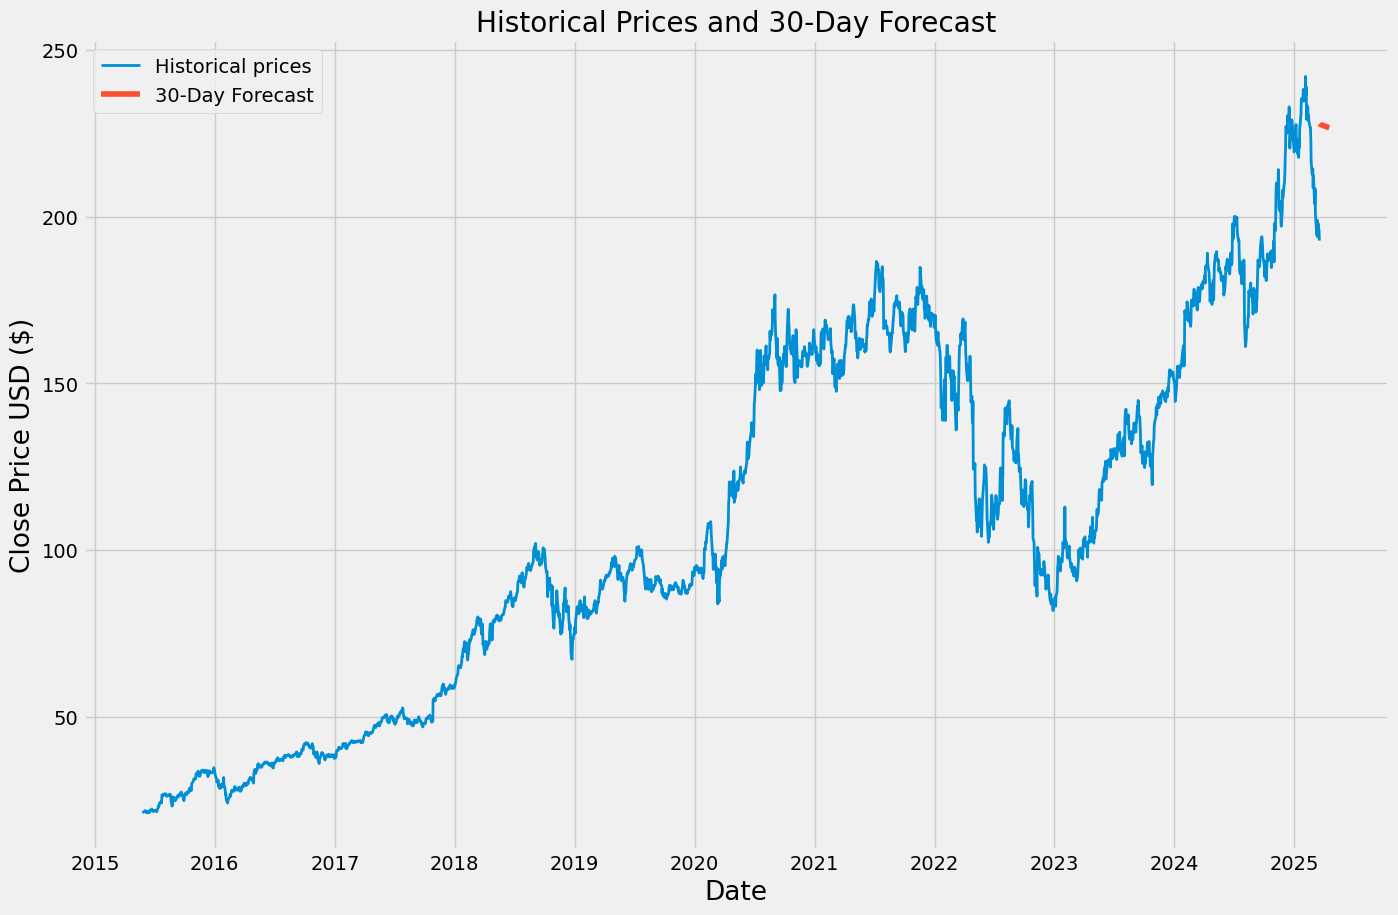

In [44]:
plt.figure(figsize=(15,10))
plt.plot(data['Close'], label='Historical prices',linewidth=2 )
plt.plot(forecast, label ='30-Day Forecast')
plt.title('Historical Prices and 30-Day Forecast')
plt.xlabel('Date', fontsize=19)
plt.ylabel('Close Price USD ($)', fontsize=19)
plt.legend()
plt.show()

In [50]:
# After training your model
from google.colab import files
model.save('lstm_stock_model.h5')

files.download("lstm_stock_model.h5")

print("✅ Model successfully saved as lstm_stock_model.h5")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Model successfully saved as lstm_stock_model.h5


In [46]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 150, 50)             │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 150, 50)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 91,955 (359.20 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 61,304 (239.47 KB)

## 📌 Project Summary: Amazon Stock Price Forecasting using LSTM

This project explores the use of deep learning for stock price forecasting using Amazon (AMZN) historical market data. I implemented a Long Short-Term Memory (LSTM) neural network — a deep learning architecture well-suited for time-series prediction — to forecast future closing prices of the stock.

---

### 🎯 Objective:
To accurately predict stock prices using real market indicators and benchmark performance against traditional models.

---

### 📊 Features Engineered:
A total of **13 advanced features**, including technical indicators and volatility metrics:

- **Price Data**: Open, High, Low, Close, Volume  
- **Moving Averages**: SMA_30, SMA_100  
- **Technical Indicators**: RSI, MACD, ATR  
- **Volatility Signal**: 30-day rolling standard deviation (Volatility_30)  
- **Bollinger Bands**: Bollinger_High, Bollinger_Low

These features emulate real-world trading signals and provide the LSTM model with strong predictive inputs.

---

### 🧠 Models Used:
1. **LSTM Neural Network** (Deep Learning)
2. **Linear Regression** (Baseline)

---

### 📏 Evaluation Metrics:
- **RMSE (Root Mean Squared Error)**
- **MAE (Mean Absolute Error)**
- **R² Score (Coefficient of Determination)**

> Results showed the LSTM model significantly outperformed Linear Regression across all metrics.

---

### 🔍 Key Insights:
- LSTM captured time-based trends and volatility better than traditional regression
- Incorporating real technical indicators (e.g., RSI, MACD) enhanced model accuracy
- The approach mirrors how algorithmic traders build predictive models in practice

---

### 🚀 Next Steps:
- Test GRU and Transformer models for performance comparison  
- Deploy via Streamlit for interactive prediction  
- Integrate real-time stock data from an API (e.g., Alpha Vantage or Yahoo Finance)

---

This project demonstrates end-to-end application of deep learning in financial time series prediction — combining technical feature engineering, rigorous evaluation, and domain knowledge.
